## Import

In [1]:
import os
import sys
import yaml
import numpy as np
import math
import matplotlib.pyplot as plt

import torch
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data.dataloader as loader
import torch.nn.functional as F

from PIL import Image
from tqdm import trange, tqdm
from collections import namedtuple

from train_dataset import DataServoStereo
import train_model as model

## Load configuartion and model

In [2]:
with open("cfg/train_real_images.yaml", "r") as f:
    config = yaml.safe_load(f)

gpu_enabled = config["gpu"]

if gpu_enabled:
    print("Trained on GPU")
else:
    print("Trained on CPU")

Trained on CPU


In [3]:
if gpu_enabled == True:
    torch.cuda.is_available()
    torch.cuda.device_count()
    torch.cuda.current_device()
    torch.cuda.device(0)
    torch.cuda.get_device_name(0)

In [4]:
if gpu_enabled == True:
    cudnn.enabled = True
    cudnn.benchmark = True
    cudnn.deterministic = True

In [5]:
arg = yaml.load(open("cfg/train_real_images.yaml", 'r'), yaml.Loader)
arg = namedtuple('Arg', arg.keys())(**arg)


In [6]:
torch.manual_seed(0)
np.random.seed(0)

In [7]:
kper = model.KeyPointGaussian(arg.sigma_kp[0], (arg.num_keypoint, *arg.im_size[1]))
if gpu_enabled ==True:
    enc = model.Encoder(arg.num_input, arg.num_keypoint, arg.growth_rate[0], arg.blk_cfg_enc, arg.drop_rate, kper).cuda()
else:
    enc = model.Encoder(arg.num_input, arg.num_keypoint, arg.growth_rate[0], arg.blk_cfg_enc, arg.drop_rate, kper)

In [8]:
def load_checkpoint(base_dir):
    cp_net = torch.load(os.path.join(base_dir, 'ckpt.pth'))
    enc.load_state_dict(cp_net['enc_state_dict'])
    print('checkpoint loaded.')

## definition of the test_function 

In [9]:
def test(loader_test):
    from skimage import transform
    color = yaml.load(open('cfg/color.yaml', 'r'), Loader=yaml.Loader)


    keypoint_pos_alle_bilder = [] 

    for i, (img) in enumerate(loader_test): # i = pictures in test folder

        if gpu_enabled ==True:
            img = img.cuda()
            # plug_mask_tensor = plug_mask_tensor.cuda()

        # forward-pass
        keypL = enc(img) # left picture
        keyp = keypL[1].detach().squeeze().cpu().numpy() #convert tensor to numpy array
        

        # keypoint_pos is the position of the keypoint in the array so also in the image
        keypoint_pos_ein_bild = [] # we probably need for visual servoing
        

        for k in range(len(keyp)): #k = die features auf jedem Bild
        
            flat_index = np.argmax(keyp[k]) # maximum value within the array
            y, x = np.unravel_index(flat_index, keyp[k].shape) #  position des maximums im array 
            keypoint_pos_ein_bild.append([x,y])
        
        keypoint_pos_alle_bilder.append(keypoint_pos_ein_bild)


        # Visualize keypoints
        keyps = np.zeros((img.size(2), img.size(3), 3), float)
        for j in range(keyp.shape[0]):
            keyps = keyps + np.tile(transform.resize(keyp[j], keyps.shape[:2])[:, :, np.newaxis], [1, 1, 3]) * \
                    np.array(color[j]).reshape(1, 1, 3)

        keyps = (keyps * 255).round().astype(np.uint8) 
        img_out = ((img.detach().squeeze().cpu().numpy() * 0.25) * 255 + 128).round().clip(0, 255).astype(np.uint8)
       
        # plug_mask = plug_mask.numpy()
        # plug_mask = plug_mask.transpose((1, 2, 0))
        # plug_mask = np.squeeze(plug_mask)

        
        if arg.num_input ==1:
            
            Image.fromarray(np.hstack((np.tile(img_out[:, :, None], [1, 1, 3]), keyps,np.uint8(np.tile(img_out[:, :, None], [1, 1, 3]) +0.8*keyps)))).save(os.path.join(arg.dir_base, 'test/{:04d}.png'.format(i)))
            # Image.fromarray(np.uint8(plug_mask) * 255).save(os.path.join(arg.dir_base, 'test/{:04d}binary.png'.format(i)))


        else:
            
            img_out = img_out.transpose((1, 2, 0)) # img has the wrong shape, therefore must be reshaped
            Image.fromarray(np.hstack((img_out, keyps,np.uint8(img_out +0.5*keyps)))).save(os.path.join(arg.dir_base, 'test/{:04d}.png'.format(i)))
            # Image.fromarray(np.uint8(plug_mask) * 255).save(os.path.join(arg.dir_base, 'test/{:04d}binary.png'.format(i)))
            

    return keypoint_pos_ein_bild,keypoint_pos_alle_bilder


## Main-function for the test

In [10]:
def main_test():

    if arg.task in ['full', 'test']:
        # directory
        if not os.path.isdir(os.path.join(arg.dir_base, 'test')):
            os.makedirs(os.path.join(arg.dir_base, 'test'))

        # dataset
        if arg.num_input == 1:
        
            print("Testen mit Graustufen-Bildern")
            ds_test = DataServoStereo(arg,False,grey=True)
        
        else:
            print("Testen mit RGB-Bildern")
            ds_test = DataServoStereo(arg,False,grey=False)

        # load database
        #data_param = {'shuffle': False}
        loader_test = loader.DataLoader(ds_test)


        # load model
        load_checkpoint(arg.dir_base)
        enc.eval()
        kper.sigma = arg.sigma_kp[1]

        # test
        print('testing...')
        keypoint_pos_ein_bild,keypoint_pos_alle_bilder = test(loader_test)
    
    return keypoint_pos_ein_bild,keypoint_pos_alle_bilder

In [11]:
keypoint_pos_ein_bild,keypoint_pos_alle_bilder = main_test()

Testen mit Graustufen-Bildern
10 testing data loaded
checkpoint loaded.
testing...


# Test für Keypointselection

In [12]:
keypoints_selected = [2,24,0,20,4,31,9,29,30,26,16]
keypoints_goal_selected = []

print(keypoint_pos_ein_bild)

for i in keypoints_selected:
    keypoints_goal_selected.append(keypoint_pos_ein_bild[i])

print(keypoints_goal_selected)

[[345, 186], [196, 145], [233, 175], [157, 105], [193, 144], [157, 182], [269, 79], [138, 175], [239, 97], [194, 181], [154, 144], [357, 174], [192, 179], [176, 186], [175, 137], [158, 171], [195, 153], [317, 79], [137, 192], [200, 180], [215, 165], [166, 188], [157, 190], [225, 174], [183, 175], [157, 127], [201, 173], [171, 180], [184, 144], [278, 168], [322, 179], [214, 174]]
[[233, 175], [183, 175], [345, 186], [215, 165], [193, 144], [214, 174], [194, 181], [278, 168], [322, 179], [201, 173], [195, 153]]


## Validation

### General settings

In [13]:
move_in_x = "0.01" # Robot movement in x-direction
move_in_y = "0.01" # Robot movement in y-direction

Take the start image and calculate the average distance from each keypoint to the other keypoints. Then sort the keypoints by distance.

In [14]:
coords = keypoint_pos_alle_bilder[0]
n = len(keypoint_pos_alle_bilder[0])


mean_dists = []

for i in range(n):
    dist_sum = 0.0
    num_points = 0
    for j in range(n):
        if i == j:
            continue
        dist = math.sqrt((coords[i][0]-coords[j][0])**2 + (coords[i][1]-coords[j][1])**2)
        dist_sum += dist
        num_points += 1
    mean_dist = dist_sum / num_points
    mean_dists.append((i, mean_dist))

mean_dists_sorted = sorted(mean_dists, key=lambda x: x[1], reverse=True)

for i, mean_dist in mean_dists_sorted:
    print("Mittlere Distanz zwischen Punkt", i, "und allen anderen Punkten:", mean_dist)

Mittlere Distanz zwischen Punkt 11 und allen anderen Punkten: 169.16884344005317
Mittlere Distanz zwischen Punkt 0 und allen anderen Punkten: 158.59113374804548
Mittlere Distanz zwischen Punkt 30 und allen anderen Punkten: 137.21144991303782
Mittlere Distanz zwischen Punkt 29 und allen anderen Punkten: 112.38320599353585
Mittlere Distanz zwischen Punkt 6 und allen anderen Punkten: 111.59422188626523
Mittlere Distanz zwischen Punkt 17 und allen anderen Punkten: 102.57035481485052
Mittlere Distanz zwischen Punkt 8 und allen anderen Punkten: 97.01684865731356
Mittlere Distanz zwischen Punkt 3 und allen anderen Punkten: 94.64401126458321
Mittlere Distanz zwischen Punkt 1 und allen anderen Punkten: 88.13796968329218
Mittlere Distanz zwischen Punkt 25 und allen anderen Punkten: 86.60383172886871
Mittlere Distanz zwischen Punkt 28 und allen anderen Punkten: 76.77196644251474
Mittlere Distanz zwischen Punkt 2 und allen anderen Punkten: 75.6718623024669
Mittlere Distanz zwischen Punkt 14 und al

Here the 5 keypoints are selected, which are used for the validation.

In [15]:
keypoint_1 = 2
keypoint_2 = 24
keypoint_3 = 4
keypoint_4 = 9
keypoint_5 = 30


print("keypoint_1 hat die Nummer: ",keypoint_1, "und die Start-Kooridnaten: ", keypoint_pos_alle_bilder[0][keypoint_1])
print("keypoint_2 hat die Nummer: ",keypoint_2, "und die Start-Kooridnaten: ", keypoint_pos_alle_bilder[0][keypoint_2])
print("keypoint_3 hat die Nummer: ",keypoint_3, "und die Start-Kooridnaten: ", keypoint_pos_alle_bilder[0][keypoint_3])
print("keypoint_4 hat die Nummer: ",keypoint_4, "und die Start-Kooridnaten: ", keypoint_pos_alle_bilder[0][keypoint_4])
print("keypoint_5 hat die Nummer: ",keypoint_5, "und die Start-Kooridnaten: ", keypoint_pos_alle_bilder[0][keypoint_5])


keypoint_1 hat die Nummer:  2 und die Start-Kooridnaten:  [235, 174]
keypoint_2 hat die Nummer:  24 und die Start-Kooridnaten:  [188, 174]
keypoint_3 hat die Nummer:  4 und die Start-Kooridnaten:  [159, 193]
keypoint_4 hat die Nummer:  9 und die Start-Kooridnaten:  [166, 199]
keypoint_5 hat die Nummer:  30 und die Start-Kooridnaten:  [321, 176]


Determine the change of the image coordinate for each of the 5 keypoints.

In [16]:
keypoint_1_pos = []
keypoint_2_pos = []
keypoint_3_pos = []
keypoint_4_pos = []
keypoint_5_pos = []


for i in range(len(keypoint_pos_alle_bilder)):
    keypoint_1_pos.append(keypoint_pos_alle_bilder[i][keypoint_1])
    keypoint_2_pos.append(keypoint_pos_alle_bilder[i][keypoint_2])
    keypoint_3_pos.append(keypoint_pos_alle_bilder[i][keypoint_3])
    keypoint_4_pos.append(keypoint_pos_alle_bilder[i][keypoint_4])
    keypoint_5_pos.append(keypoint_pos_alle_bilder[i][keypoint_5])


Extract the x and y coordinate from the image coordinates.

In [17]:
keypoint_1_x = []
keypoint_1_y = []
keypoint_2_x = []
keypoint_2_y = []
keypoint_3_x = []
keypoint_3_y = []
keypoint_4_x = []
keypoint_4_y = []
keypoint_5_x = []
keypoint_5_y = []

for i in range(len(keypoint_1_pos)):
    keypoint_1_x.append(keypoint_1_pos[i][0])
    keypoint_1_y.append(keypoint_1_pos[i][1])
    keypoint_2_x.append(keypoint_2_pos[i][0])
    keypoint_2_y.append(keypoint_2_pos[i][1])
    keypoint_3_x.append(keypoint_3_pos[i][0])
    keypoint_3_y.append(keypoint_3_pos[i][1])
    keypoint_4_x.append(keypoint_4_pos[i][0])
    keypoint_4_y.append(keypoint_4_pos[i][1])
    keypoint_5_x.append(keypoint_5_pos[i][0])
    keypoint_5_y.append(keypoint_5_pos[i][1])

print("keypoint_1_pos_x: ", keypoint_1_x)
print("keypoint_2_pos_x: ", keypoint_2_x)
print("keypoint_3_pos_x: ", keypoint_3_x)
print("keypoint_4_pos_x: ", keypoint_4_x)
print("keypoint_5_pos_x: ", keypoint_5_x)

print("\n")

print("keypoint_1_pos_y: ", keypoint_1_y)
print("keypoint_2_pos_y: ", keypoint_2_y)
print("keypoint_3_pos_y: ", keypoint_3_y)
print("keypoint_4_pos_y: ", keypoint_4_y)
print("keypoint_5_pos_y: ", keypoint_5_y)


keypoint_1_pos_x:  [235, 233, 233, 234, 234, 236, 237, 236, 235, 233]
keypoint_2_pos_x:  [188, 188, 188, 188, 187, 187, 186, 185, 184, 183]
keypoint_3_pos_x:  [159, 161, 163, 166, 165, 175, 174, 184, 188, 193]
keypoint_4_pos_x:  [166, 169, 172, 175, 178, 181, 184, 188, 191, 194]
keypoint_5_pos_x:  [321, 318, 318, 320, 319, 322, 322, 323, 323, 322]


keypoint_1_pos_y:  [174, 176, 175, 175, 174, 174, 173, 174, 174, 175]
keypoint_2_pos_y:  [174, 174, 174, 174, 174, 173, 174, 174, 175, 175]
keypoint_3_pos_y:  [193, 188, 183, 176, 169, 165, 159, 155, 149, 144]
keypoint_4_pos_y:  [199, 198, 196, 195, 193, 191, 189, 187, 184, 181]
keypoint_5_pos_y:  [176, 182, 183, 182, 181, 181, 180, 180, 180, 179]


### Validation in the direction of the y-axis

Plot 1: Change of the x-image coordinate in realization to the robot movement in x-direction.

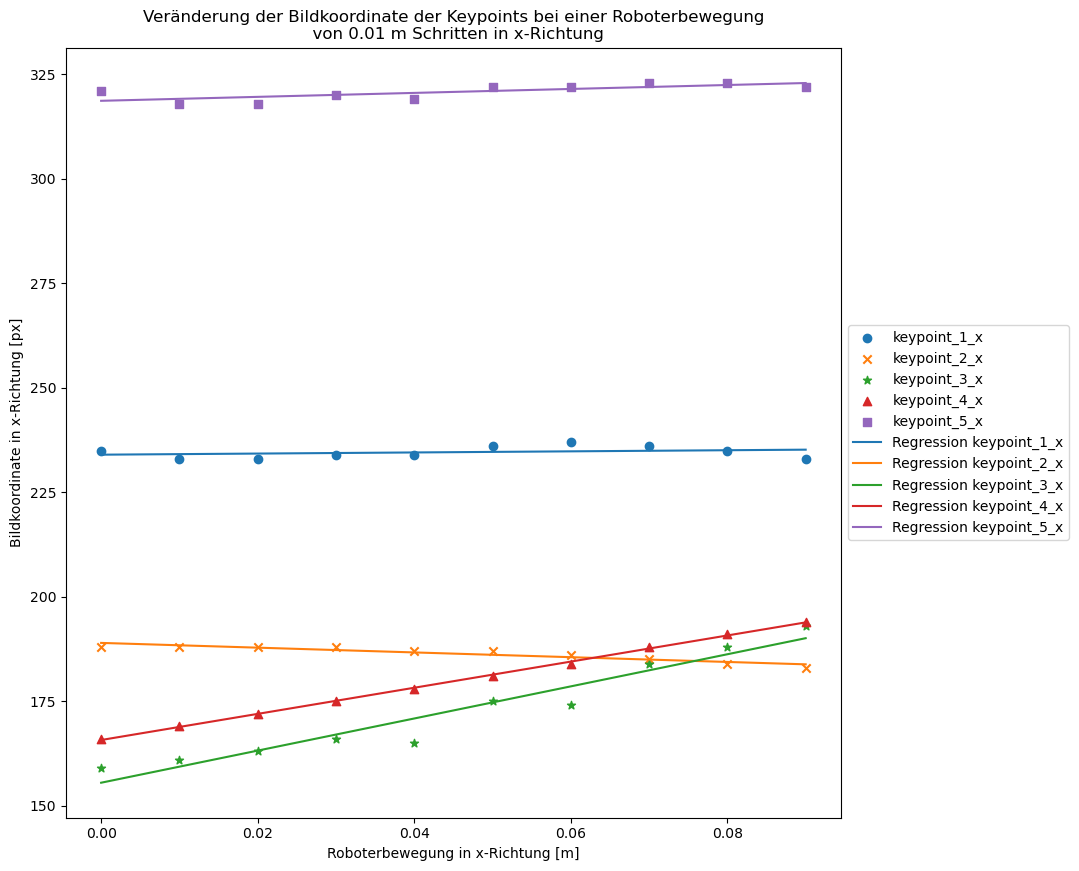

In [18]:
if move_in_x == "0":
    print("keine Verschiebung in x-Richtung,daher wird das Diagramm nicht geplottet")
else:
    x_axis = np.arange(0, len(keypoint_1_x), 1) * float(move_in_x)

    coefficients_keypoint_1 = np.polyfit(x_axis, keypoint_1_x, 1)
    coefficients_keypoint_2 = np.polyfit(x_axis, keypoint_2_x, 1)
    coefficients_keypoint_3 = np.polyfit(x_axis, keypoint_3_x, 1)
    coefficients_keypoint_4 = np.polyfit(x_axis, keypoint_4_x, 1)
    coefficients_keypoint_5 = np.polyfit(x_axis, keypoint_5_x, 1)

    figure = plt.figure(figsize=(10, 10))
    plt.scatter(x_axis, keypoint_1_x, label = "keypoint_1_x",marker='o')
    plt.scatter(x_axis, keypoint_2_x, label = "keypoint_2_x",marker='x')
    plt.scatter(x_axis, keypoint_3_x, label = "keypoint_3_x",marker='*')
    plt.scatter(x_axis, keypoint_4_x, label = "keypoint_4_x",marker='^')
    plt.scatter(x_axis, keypoint_5_x, label = "keypoint_5_x",marker='s')

    plt.plot(x_axis, np.polyval(coefficients_keypoint_1, x_axis), label='Regression keypoint_1_x')
    plt.plot(x_axis, np.polyval(coefficients_keypoint_2, x_axis), label='Regression keypoint_2_x')
    plt.plot(x_axis, np.polyval(coefficients_keypoint_3, x_axis), label='Regression keypoint_3_x')
    plt.plot(x_axis, np.polyval(coefficients_keypoint_4, x_axis), label='Regression keypoint_4_x')
    plt.plot(x_axis, np.polyval(coefficients_keypoint_5, x_axis), label='Regression keypoint_5_x')

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('Roboterbewegung in x-Richtung [m]')
    plt.ylabel('Bildkoordinate in x-Richtung [px]')
    plt.title('Veränderung der Bildkoordinate der Keypoints bei einer Roboterbewegung\n  von ' + move_in_x + ' m Schritten in x-Richtung')


Standard deviation for the individual keypoints in x-direction

In [19]:
if move_in_x == "0":
    print("keine Verschiebung in x-Richtung,daher werden diese Werte nicht berechnet")
else:

    slope_keypoint_1 = coefficients_keypoint_1[0]
    slope_keypoint_2 = coefficients_keypoint_2[0]
    slope_keypoint_3 = coefficients_keypoint_3[0]
    slope_keypoint_4 = coefficients_keypoint_4[0]
    slope_keypoint_5 = coefficients_keypoint_5[0]


    intercept_keypoint_1 = coefficients_keypoint_1[1]
    intercept_keypoint_2 = coefficients_keypoint_2[1]
    intercept_keypoint_3 = coefficients_keypoint_3[1]
    intercept_keypoint_4 = coefficients_keypoint_4[1]
    intercept_keypoint_5 = coefficients_keypoint_5[1]



    keyppoint_1_x_pred = slope_keypoint_1 * x_axis + intercept_keypoint_1
    keyppoint_2_x_pred  = slope_keypoint_2 * x_axis + intercept_keypoint_2
    keyppoint_3_x_pred  = slope_keypoint_3 * x_axis + intercept_keypoint_3
    keyppoint_4_x_pred  = slope_keypoint_4 * x_axis + intercept_keypoint_4
    keyppoint_5_x_pred  = slope_keypoint_5 * x_axis + intercept_keypoint_5

    pixelabweichung_keypoint_1_x = keypoint_1_x - keyppoint_1_x_pred
    pixelabweichung_keypoint_2_x = keypoint_2_x - keyppoint_2_x_pred
    pixelabweichung_keypoint_3_x = keypoint_3_x - keyppoint_3_x_pred
    pixelabweichung_keypoint_4_x = keypoint_4_x - keyppoint_4_x_pred
    pixelabweichung_keypoint_5_x = keypoint_5_x - keyppoint_5_x_pred


    # Berechnen der Standardabweichung

    std_keypoint_1 = np.std(pixelabweichung_keypoint_1_x) 
    std_keypoint_2 = np.std(pixelabweichung_keypoint_2_x) 
    std_keypoint_3 = np.std(pixelabweichung_keypoint_3_x) 
    std_keypoint_4 = np.std(pixelabweichung_keypoint_4_x) 
    std_keypoint_5 = np.std(pixelabweichung_keypoint_5_x) 


    print("Standardabweichung Keypoint 1:", std_keypoint_1) # in Pixel
    print("Standardabweichung Keypoint 2:", std_keypoint_2) # in Pixel
    print("Standardabweichung Keypoint 3:", std_keypoint_3) # in Pixel
    print("Standardabweichung Keypoint 4:", std_keypoint_4) # in Pixel
    print("Standardabweichung Keypoint 5:", std_keypoint_5) # in Pixel

Standardabweichung Keypoint 1: 1.3012814197295424
Standardabweichung Keypoint 2: 0.6020168124099547
Standardabweichung Keypoint 3: 2.924919061299221
Standardabweichung Keypoint 4: 0.276339711883102
Standardabweichung Keypoint 5: 1.231407177323419


Standard deviation in x-direction, keypoints in comparison

In [20]:
if move_in_x == "0":
    print("keine Verschiebung in x-Richtung,daher werden diese Werte nicht berechnet")
else:
    gradient_keypoint_1_x = coefficients_keypoint_1[0] # Steigung der Regressionsgeraden
    gradient_keypoint_2_x = coefficients_keypoint_2[0] # Steigung der Regressionsgeraden
    gradient_keypoint_3_x = coefficients_keypoint_3[0] # Steigung der Regressionsgeraden
    gradient_keypoint_4_x = coefficients_keypoint_4[0] # Steigung der Regressionsgeraden
    gradient_keypoint_5_x = coefficients_keypoint_5[0] # Steigung der Regressionsgeraden

    print("Steigung Keypoint 1 [px pro Meter]:", gradient_keypoint_1_x) # in Pixel pro Meter
    print("Steigung Keypoint 2 [px pro Meter]:", gradient_keypoint_2_x) # in Pixel pro Meter
    print("Steigung Keypoint 3 [px pro Meter]:", gradient_keypoint_3_x) # in Pixel pro Meter
    print("Steigung Keypoint 4 [px pro Meter]:", gradient_keypoint_4_x) # in Pixel pro Meter
    print("Steigung Keypoint 5 [px pro Meter]:", gradient_keypoint_5_x) # in Pixel pro Meter

    # Berechne die Standardabweichung der Steigungen mit numpy
    std_gradient_x = np.std([gradient_keypoint_1_x, gradient_keypoint_2_x, gradient_keypoint_3_x, gradient_keypoint_4_x, gradient_keypoint_5_x])
    print("Standardabweichung der Steigungen [px pro Meter]: ", std_gradient_x) # in Pixel pro Meter

Steigung Keypoint 1 [px pro Meter]: 13.333333333335283
Steigung Keypoint 2 [px pro Meter]: -56.96969696969567
Steigung Keypoint 3 [px pro Meter]: 384.2424242424252
Steigung Keypoint 4 [px pro Meter]: 312.72727272727406
Steigung Keypoint 5 [px pro Meter]: 47.27272727273055
Standardabweichung der Steigungen [px pro Meter]:  174.88787960172792


### Validation in the direction of the y-axis

Plot 2: Change of y-image coordinate in realization to robot movement in y-direction

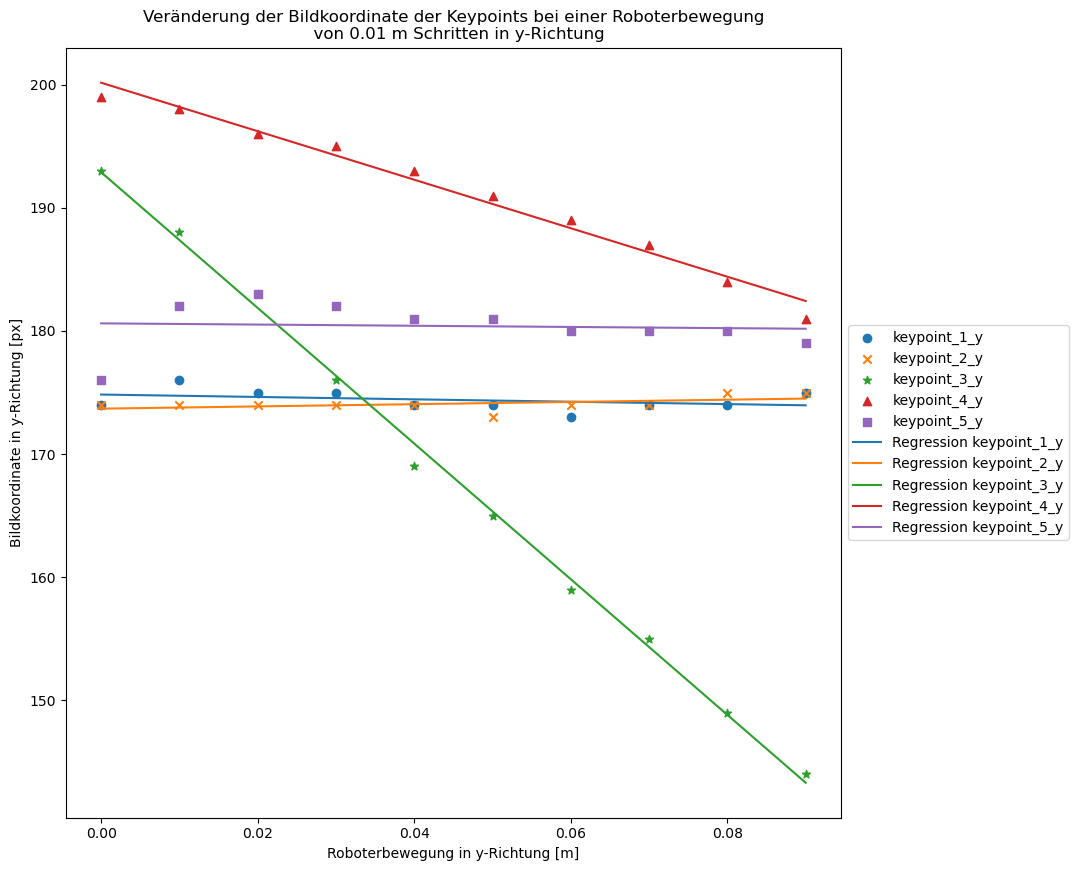

In [21]:
if move_in_y == "0":
    print("keine Verschiebung in y-Richtung,daher wird das Diagramm nicht geplottet")
else:
    y_axis = np.arange(0, len(keypoint_1_y), 1) * float(move_in_y)

    coefficients_keypoint_1 = np.polyfit(y_axis, keypoint_1_y, 1)
    coefficients_keypoint_2 = np.polyfit(y_axis, keypoint_2_y, 1)
    coefficients_keypoint_3 = np.polyfit(y_axis, keypoint_3_y, 1)
    coefficients_keypoint_4 = np.polyfit(y_axis, keypoint_4_y, 1)
    coefficients_keypoint_5 = np.polyfit(y_axis, keypoint_5_y, 1)

    figure = plt.figure(figsize=(10, 10))
    plt.scatter(y_axis, keypoint_1_y, label = "keypoint_1_y",marker='o')
    plt.scatter(y_axis, keypoint_2_y, label = "keypoint_2_y",marker='x')
    plt.scatter(y_axis, keypoint_3_y, label = "keypoint_3_y",marker='*')
    plt.scatter(y_axis, keypoint_4_y, label = "keypoint_4_y",marker='^')
    plt.scatter(y_axis, keypoint_5_y, label = "keypoint_5_y",marker='s')


    plt.plot(y_axis, np.polyval(coefficients_keypoint_1, y_axis), label='Regression keypoint_1_y')
    plt.plot(y_axis, np.polyval(coefficients_keypoint_2, y_axis), label='Regression keypoint_2_y')
    plt.plot(y_axis, np.polyval(coefficients_keypoint_3, y_axis), label='Regression keypoint_3_y')
    plt.plot(y_axis, np.polyval(coefficients_keypoint_4, y_axis), label='Regression keypoint_4_y')
    plt.plot(y_axis, np.polyval(coefficients_keypoint_5, y_axis), label='Regression keypoint_5_y')



    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('Roboterbewegung in y-Richtung [m]')
    plt.ylabel('Bildkoordinate in y-Richtung [px]')
    plt.title('Veränderung der Bildkoordinate der Keypoints bei einer Roboterbewegung\n  von ' + move_in_y + ' m Schritten in y-Richtung')


Standard deviation of the individual keypoints in y-direction

In [22]:
if move_in_y == "0":
    print("keine Verschiebung in y-Richtung,daher werden diese Werte nicht berechnet")
else:

    slope_keypoint_1 = coefficients_keypoint_1[0]
    slope_keypoint_2 = coefficients_keypoint_2[0]
    slope_keypoint_3 = coefficients_keypoint_3[0]
    slope_keypoint_4 = coefficients_keypoint_4[0]
    slope_keypoint_5 = coefficients_keypoint_5[0]


    intercept_keypoint_1 = coefficients_keypoint_1[1]
    intercept_keypoint_2 = coefficients_keypoint_2[1]
    intercept_keypoint_3 = coefficients_keypoint_3[1]
    intercept_keypoint_4 = coefficients_keypoint_4[1]
    intercept_keypoint_5 = coefficients_keypoint_5[1]



    keyppoint_1_y_pred = slope_keypoint_1 * y_axis + intercept_keypoint_1
    keyppoint_2_y_pred  = slope_keypoint_2 * y_axis + intercept_keypoint_2
    keyppoint_3_y_pred  = slope_keypoint_3 * y_axis + intercept_keypoint_3
    keyppoint_4_y_pred  = slope_keypoint_4 * y_axis + intercept_keypoint_4
    keyppoint_5_y_pred  = slope_keypoint_5 * y_axis + intercept_keypoint_5

    pixelabweichung_keypoint_1_y = keypoint_1_y - keyppoint_1_y_pred
    pixelabweichung_keypoint_2_y = keypoint_2_y - keyppoint_2_y_pred
    pixelabweichung_keypoint_3_y = keypoint_3_y - keyppoint_3_y_pred
    pixelabweichung_keypoint_4_y = keypoint_4_y - keyppoint_4_y_pred
    pixelabweichung_keypoint_5_y = keypoint_5_y - keyppoint_5_y_pred


   # Calculate the standard deviation 

    std_keypoint_1 = np.std(pixelabweichung_keypoint_1_y) 
    std_keypoint_2 = np.std(pixelabweichung_keypoint_2_y) 
    std_keypoint_3 = np.std(pixelabweichung_keypoint_3_y) 
    std_keypoint_4 = np.std(pixelabweichung_keypoint_4_y) 
    std_keypoint_5 = np.std(pixelabweichung_keypoint_5_y) 


    print("Standardabweichung Keypoint 1:", std_keypoint_1) # in Pixel
    print("Standardabweichung Keypoint 2:", std_keypoint_2) # in Pixel
    print("Standardabweichung Keypoint 3:", std_keypoint_3) # in Pixel
    print("Standardabweichung Keypoint 4:", std_keypoint_4) # in Pixel
    print("Standardabweichung Keypoint 5:", std_keypoint_5) # in Pixel

Standardabweichung Keypoint 1: 0.7499494932488694
Standardabweichung Keypoint 2: 0.47097577625412906
Standardabweichung Keypoint 3: 0.837745893346059
Standardabweichung Keypoint 4: 0.7761599335344753
Standardabweichung Keypoint 5: 1.8494880536532436


Standard deviation in y-direction, keypoints in comparison

In [23]:
if move_in_y == "0":
    print("keine Verschiebung in y-Richtung,daher werden diese Werte nicht berechnet")
else:

    gradient_keypoint_1_y = coefficients_keypoint_1[0] # Steigung der Regressionsgeraden
    gradient_keypoint_2_y = coefficients_keypoint_2[0] # Steigung der Regressionsgeraden
    gradient_keypoint_3_y = coefficients_keypoint_3[0] # Steigung der Regressionsgeraden
    gradient_keypoint_4_y = coefficients_keypoint_4[0] # Steigung der Regressionsgeraden
    gradient_keypoint_5_y = coefficients_keypoint_5[0] # Steigung der Regressionsgeraden

    print("Steigung Keypoint 1 [px pro Meter]:", gradient_keypoint_1_y) # in Pixel pro Meter
    print("Steigung Keypoint 2 [px pro Meter]:", gradient_keypoint_2_y) # in Pixel pro Meter
    print("Steigung Keypoint 3 [px pro Meter]:", gradient_keypoint_3_y) # in Pixel pro Meter
    print("Steigung Keypoint 4 [px pro Meter]:", gradient_keypoint_4_y) # in Pixel pro Meter
    print("Steigung Keypoint 5 [px pro Meter]:", gradient_keypoint_5_y) # in Pixel pro Meter
    


   # Calculate the standard deviation of the slopes with numpy
    std_gradient_y = np.std([gradient_keypoint_1_y, gradient_keypoint_2_y, gradient_keypoint_3_y, gradient_keypoint_4_y, gradient_keypoint_5_y])
    print("Standardabweichung der Steigungen [px pro Meter]: ", std_gradient_y)

Steigung Keypoint 1 [px pro Meter]: -9.696969696967944
Steigung Keypoint 2 [px pro Meter]: 9.090909090911149
Steigung Keypoint 3 [px pro Meter]: -550.9090909090888
Steigung Keypoint 4 [px pro Meter]: -196.9696969696954
Steigung Keypoint 5 [px pro Meter]: -4.848484848482778
Standardabweichung der Steigungen [px pro Meter]:  214.007406134985


## ibvs-Regler

In [24]:
def getStackFeatureJacobian(featurePts,z=1):

    Jf_Stack = []
    for i in range(len(featurePts)):
        u = featurePts[i] [0]
        v = featurePts[i] [1]
        Jf = np.array([[-1/z, 0, u/z, u*v, -(1 + u**2), v],
               [0, -1/z, v/z, 1 + v**2, -v*u, -u]])
        
        if i ==0:
            Jf_Stack = Jf
        
        else:
        
            Jf_Stack= np.vstack((Jf_Stack,Jf))

    return Jf_Stack

In [25]:
Jf_Stack = getStackFeatureJacobian(keypoint_pos_alle_bilder[1]) # Jf_Stack immer von aktuellem Bild

In [26]:
# Gefühlt genau Falsch rum

f_act = np.array(keypoint_pos_alle_bilder[1]) # aktuelles Bild

f_des = np.array(keypoint_pos_alle_bilder[0]) # Zielbild

kIBVS = 0.1 # verstärkung default 0.001

In [27]:
def ibvsController(Jf, f_act, f_des, kIBVS):
    e_u = f_des[:,0] - f_act[:,0]
    e_v = f_des[:,1] - f_act[:,1]
    j= 1
    k= 1
    # Build up error array
    e = np.zeros((2*len(e_u), 1))
    
    for i in range(2*len(e_u)):
        if (i % 2 == 0):
            e[i] = e_v[k-1]
            k = k + 1
        else:
            e[i] = e_u[j-1]
            j = j + 1

    dp = kIBVS*(np.linalg.inv(Jf.T@Jf))@Jf.T@e
    return dp

In [28]:
dp = ibvsController(Jf_Stack, f_act, f_des, kIBVS)
print(dp)

[[-5.14498982e-01]
 [ 1.58231029e+00]
 [ 3.37048896e-03]
 [ 2.15888397e-05]
 [ 2.46486122e-05]
 [-4.97160669e-03]]
